In [1]:
import json
import os
import itertools


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch


from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from torchtext.vocab import build_vocab_from_iterator

# TODO: add n-gram edit distance

In [2]:
# # საჭმელი
# # საჭმლეი
# distance.edit_distance(['სა', 'აჭ', 'ჭმ', 'მე', 'ელ', 'ლი'], ['სა', 'აჭ', 'ჭმ', 'მლ', 'ლე', 'ეი'])
# distance.edit_distance(['საჭ', 'აჭმ', 'ჭმე', 'მელ', 'ელი'], ['საჭ', 'აჭმ', 'ჭმლ', 'მლე', 'ლეი'])

# Data

In [3]:
data = pd.read_csv('csv/test.csv')
data

,Unnamed: 0,word,lemma,pos_tag,freq,word_length,lemma_length,ratio,lemma_length_category,word_length_category,ratio_category,reported_speech,freq_category
0,143445,საჩემოა,საჩემო,A,10,7,6,1.166667,low,low,greater,False,medium
1,805277,საჭმელ-სასმელით,საჭმელსასმელი,N,15,15,13,1.153846,high,high,greater,False,medium
2,902975,დავნაძლევდით,დანაძლევება,V,4,12,11,1.090909,high,high,greater,False,medium
3,55733,ჯორჯი,ჯორჯ,N,330,5,4,1.250000,low,low,greater,False,high
4,228515,გამეშვი,გაშვება,V,13,7,7,1.000000,low,low,equal,False,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...
410093,671912,ყმაშია,ყმა,N,2,6,3,2.000000,low,low,greater,False,low
410094,339503,სათხარი,სათხარი,A,1,7,7,1.000000,low,low,equal,False,low
410095,1060380,ასანთმასალებისკენ,ასანთმასალა,N,1,17,11,1.545455,high,high,greater,False,low
410096,1315693,პაულუმაც,პაულუ,N,4,8,5,1.600000,low,low,greater,False,medium


In [4]:
# data = data.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
# data

## Preparation

In [5]:
MAX_LENGTH = 37
AVG_LENGTH = data.lemma.str.len().mean()
AVG_LENGTH

8.114172709937625

In [6]:

from Lemmatization.evaluation.evaluation import LemmatizatorEvaluator, EVALUATION_PATH
from Lemmatization.evaluation.metrics import AccuracyMetric, EditDistanceMetric, Metrics

evaluator = LemmatizatorEvaluator(data, Metrics([AccuracyMetric(), EditDistanceMetric()]), EVALUATION_PATH, 'base_model', MAX_LENGTH)

# Model

In [7]:
MODEL_NAME = 'base_model_v0.pt'
MODEL_WEIGHTS = 'base_model_v2.pt'

In [8]:
model = torch.jit.load(os.path.join('models', MODEL_NAME))
model.load_state_dict(torch.load(os.path.join('weights', MODEL_WEIGHTS)))
model.eval()
print(f'Number of Parameters: {sum(p.numel() for p in model.parameters())}')

Number of Parameters: 57447


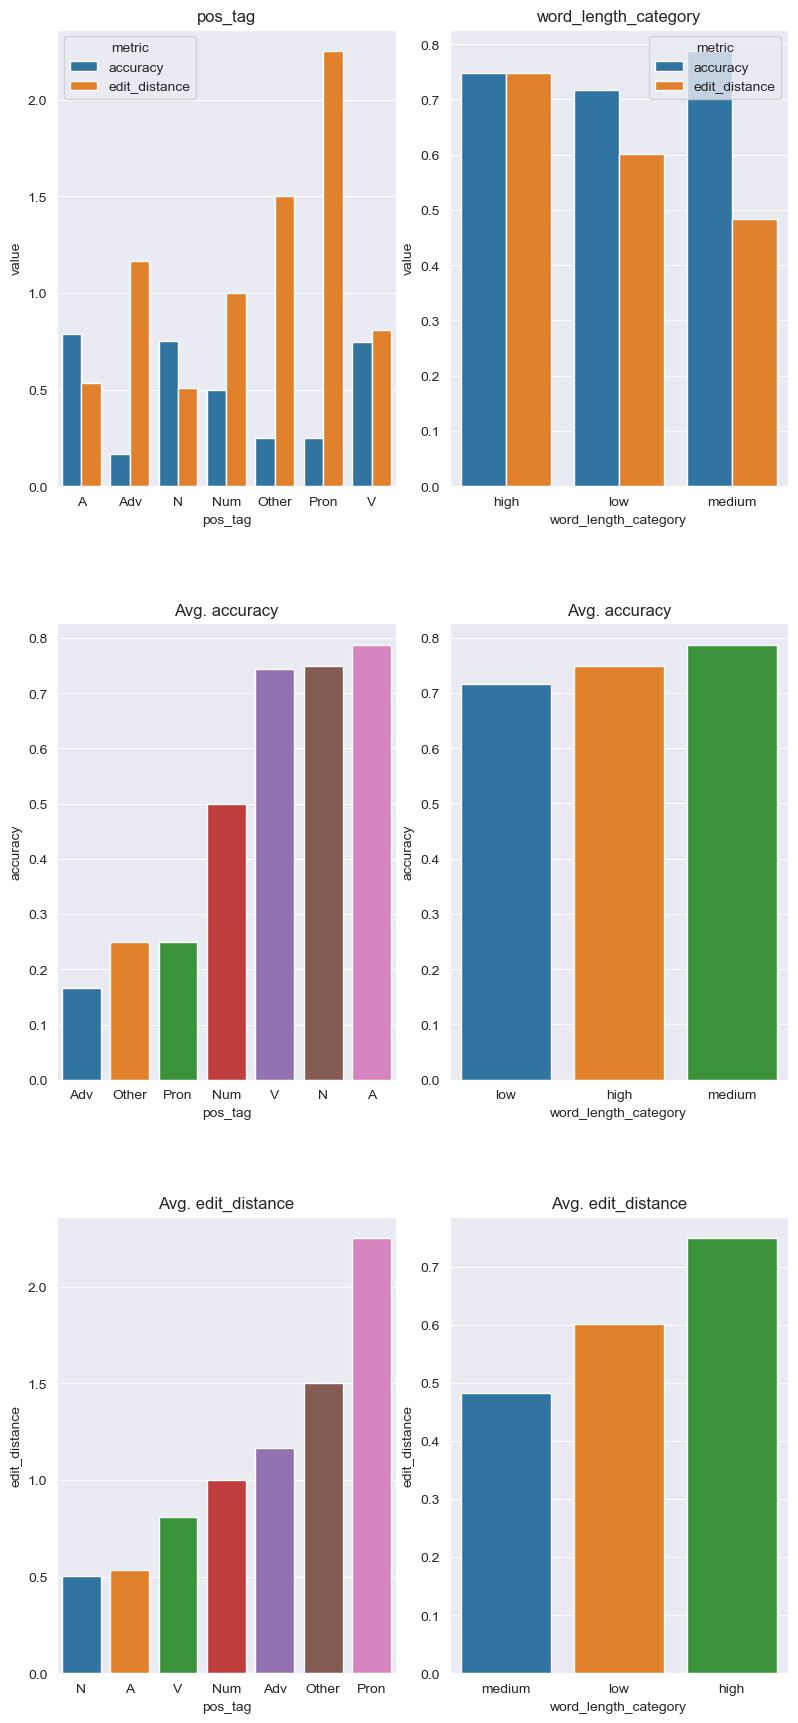

In [9]:
evaluator.evaluate(model, ['pos_tag', 'word_length_category'])

# Evaluation

In [8]:
def get_tokens(t):
    yield from list(t)

UNK_TOKEN = '<unk>'
EOW_TOKEN = '<end>'
PAD_TOKEN = '<pad>'
SOW_TOKEN = '<start>'

vocab = build_vocab_from_iterator(iterator=get_tokens(itertools.chain(data['word'], data['lemma'])),
                                  specials=[EOW_TOKEN, UNK_TOKEN, PAD_TOKEN, SOW_TOKEN],
                                  special_first=False
                                  )
vocab.set_default_index(vocab[UNK_TOKEN])

def word_to_seq(word: str):
    return torch.tensor(vocab(list(word)) + [vocab[EOW_TOKEN]])

In [9]:
class LemmaDataSet(Dataset):
    def __init__(self, data_frame: pd.DataFrame):
        self.data = data_frame

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx: int) -> (str, str):
        row = self.data.iloc[idx]
        return row['word'], row['lemma']


In [10]:
def coallate_words(batch):
    word_list, lemma_list = [torch.zeros(MAX_LENGTH, dtype=torch.int64)], [torch.zeros(MAX_LENGTH, dtype=torch.int64)]
    for word, lemma in batch:
        word_list.append(word_to_seq(word))
        lemma_list.append(word_to_seq(lemma))


    return pad_sequence(word_list, batch_first=True, padding_value=vocab[PAD_TOKEN])[1:], pad_sequence(lemma_list, batch_first=True, padding_value=vocab[PAD_TOKEN])[1:]

In [11]:
def tensors_to_words(t):
    return ["".join([vocab.get_itos()[char] if char != vocab[UNK_TOKEN] else '@' for char in word if char != vocab[PAD_TOKEN] and char != vocab[EOW_TOKEN]]) for word in t]

In [12]:
# Metrics
def edit_distances(target: str, pred: str):
    return distance.edit_distance(target, pred)

def accurecy(target: str, pred: str):
    return 1 if target == pred else 0

In [13]:
def evaluate(model, loader):
    pred = {}
    for i, (x, y) in enumerate(loader):
        y_pred = model(y).argmax(dim=2)
        x = tensors_to_words(x)
        y_pred = tensors_to_words(y_pred)
        for x_i, y_pred_i in zip(x, y_pred):
            pred[x_i] = y_pred_i
    return pd.DataFrame.from_dict(pred, orient='index', columns=['pred'])

In [14]:
def apply_metrics(df):
    df['edit_distance'] = df.apply(lambda row: edit_distances(row.lemma, row.pred), axis=1)
    df['accuracy'] = df.apply(lambda row: accurecy(row.lemma, row.pred), axis=1)
    return df

In [15]:
def evaluate_category(data, category, worst=3):
    print(f'Top {worst} worst predictions by {category}')
    for c in data[category].unique():
        worst_preds = data[data[category] == c].sort_values(by='edit_distance', ascending=False)[['word', 'lemma', 'pred', 'edit_distance']]
        print(f'Type: {c}')
        for i, row in enumerate(worst_preds.values.tolist()[:worst]):
            print(f'{i + 1}. Edit distance: {row[3]}', f'Word: {row[0]}', f'Lemma: {row[1]}', f'Prediction: {row[2]}', sep='\n')
        print()
     
    groupped = data.groupby(category)
    df = groupped.accuracy.mean().to_frame()
    df['edit_distance'] = groupped.edit_distance.mean()
    df['avg_len'] = groupped.lemma.apply(lambda x: x.str.len().mean())
    
    fig, axs = plt.subplots(nrows=5, figsize=(8, 17))
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.3)

    # Average Edit Distance - Avg. Number of character differences between target and predicted words
    # Normalized Edit Distance - Average Edit Distance / Avg.Length of a target word by category
    df['norm_distance'] = df['edit_distance'] / df['avg_len']

    # Average Inverse Distance is computed in a following manner:
    # 1 - Normalized Edit Distance

    df['inv_distance'] = 1 - df['norm_distance']  
    print(df)
    
    df.reset_index(inplace=True)

    axs[2].set_title('Avg. Edit Distance')
    sns.barplot(df.sort_values(by='edit_distance', ascending=True), x=category, y='edit_distance', ax=axs[2])
    axs[3].set_title('Avg. Normalized Edit Distance')
    sns.barplot(df.sort_values(by='norm_distance', ascending=True), x=category, y='norm_distance', ax=axs[3])
    axs[4].set_title('Avg. Inverse Edit Distance')
    sns.barplot(df.sort_values(by='inv_distance', ascending=False), x=category,  y='inv_distance', ax=axs[4])

    axs[1].set_title('Avg. Accuracy')
    sns.barplot(df.sort_values(by='accuracy', ascending=False), x=category, y='accuracy', ax=axs[1])

    df_melted = df.melt(id_vars=category, var_name='metric', value_name='value', value_vars=['accuracy', 'inv_distance'])
    sns.barplot(df_melted, x=category, y='value', hue='metric', ax=axs[0])


In [16]:
loader = DataLoader(LemmaDataSet(data), batch_size=128, collate_fn=coallate_words)
pred_df = evaluate(model, loader)
pred_df

,pred
საჩემოა,საჩემო
საჭმელ-სასმელით,საჭმელსასმელი
დავნაძლევდით,დანაძლევება
ჯორჯი,ჯორჯი
გამეშვი,გაშვება
...,...
ყმაშია,ყმა
სათხარი,სათხარი
ასანთმასალებისკენ,ასანთმასალი
პაულუმაც,პაულუ


In [40]:
# Metrics
from abc import ABC
from dataclasses import dataclass
from typing import List, Protocol

import pandas as pd
import torch
from nltk.metrics import distance

Metrics = None

class Metric(ABC):

    @property
    def name(self) -> str:
        return 'Metric'

    def compute(self, target: str, prediction: str) -> float:
        pass



@dataclass
class AccuracyMetric(Metric):

    @property
    def name(self) -> str:
        return 'accuracy'

    def compute(self, target: str, prediction: str) -> float:
        return 1 if target == prediction else 0


@dataclass
class EditDistanceMetric(Metric):

    @property
    def name(self) -> str:
        return 'edit_distance'

    def compute(self, target: str, prediction: str) -> float:
        return distance.edit_distance(target, prediction)


@dataclass
class Metrics:
    _metrics: List[Metric]

    def compute(self, df: pd.DataFrame, x: str, y: str) -> pd.DataFrame:
        for metric in self._metrics:
            df[metric.name] = df.apply(lambda row: metric.compute(row[x], row[y]), axis=1)
        return df

    @property
    def metrics(self) -> List[str]:
        return [metric.name for metric in self._metrics]



In [41]:

metrics = Metrics([AccuracyMetric(), EditDistanceMetric()])
result_df = metrics.compute(result_df, 'lemma', 'pred')
result_df

,Unnamed: 0,lemma,pos_tag,freq,word_length,lemma_length,ratio,lemma_length_category,word_length_category,ratio_category,reported_speech,freq_category,pred,edit_distance,accuracy
საჩემოა,143445,საჩემო,A,10,7,6,1.166667,low,low,greater,False,medium,საჩემო,0,1
საჭმელ-სასმელით,805277,საჭმელსასმელი,N,15,15,13,1.153846,high,high,greater,False,medium,საჭმელსასმელი,0,1
დავნაძლევდით,902975,დანაძლევება,V,4,12,11,1.090909,high,high,greater,False,medium,დანაძლევება,0,1
ჯორჯი,55733,ჯორჯ,N,330,5,4,1.250000,low,low,greater,False,high,ჯორჯი,1,0
გამეშვი,228515,გაშვება,V,13,7,7,1.000000,low,low,equal,False,medium,გაშვება,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ყმაშია,671912,ყმა,N,2,6,3,2.000000,low,low,greater,False,low,ყმა,0,1
სათხარი,339503,სათხარი,A,1,7,7,1.000000,low,low,equal,False,low,სათხარი,0,1
ასანთმასალებისკენ,1060380,ასანთმასალა,N,1,17,11,1.545455,high,high,greater,False,low,ასანთმასალი,1,0
პაულუმაც,1315693,პაულუ,N,4,8,5,1.600000,low,low,greater,False,medium,პაულუ,0,1


In [17]:
result_df = data.set_index('word').merge(pred_df, left_index=True, right_index=True)
result_df = apply_metrics(result_df)
result_df

,Unnamed: 0,lemma,pos_tag,freq,word_length,lemma_length,ratio,lemma_length_category,word_length_category,ratio_category,reported_speech,freq_category,pred,edit_distance,accuracy
საჩემოა,143445,საჩემო,A,10,7,6,1.166667,low,low,greater,False,medium,საჩემო,0,1
საჭმელ-სასმელით,805277,საჭმელსასმელი,N,15,15,13,1.153846,high,high,greater,False,medium,საჭმელსასმელი,0,1
დავნაძლევდით,902975,დანაძლევება,V,4,12,11,1.090909,high,high,greater,False,medium,დანაძლევება,0,1
ჯორჯი,55733,ჯორჯ,N,330,5,4,1.250000,low,low,greater,False,high,ჯორჯი,1,0
გამეშვი,228515,გაშვება,V,13,7,7,1.000000,low,low,equal,False,medium,გაშვება,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ყმაშია,671912,ყმა,N,2,6,3,2.000000,low,low,greater,False,low,ყმა,0,1
სათხარი,339503,სათხარი,A,1,7,7,1.000000,low,low,equal,False,low,სათხარი,0,1
ასანთმასალებისკენ,1060380,ასანთმასალა,N,1,17,11,1.545455,high,high,greater,False,low,ასანთმასალი,1,0
პაულუმაც,1315693,პაულუ,N,4,8,5,1.600000,low,low,greater,False,medium,პაულუ,0,1


In [259]:
result_df = result_df.reset_index()
result_df

,index,word,lemma,pos_tag,freq,word_length,lemma_length,ratio,lemma_length_category,word_length_category,ratio_category,reported_speech,freq_category,not_in_train,pred,edit_distance,accuracy
0,0,საჩემოა,საჩემო,A,10,7,6,1.166667,low,low,greater,False,medium,False,საჩემო,0,1
1,1,საჭმელ-სასმელით,საჭმელსასმელი,N,15,15,13,1.153846,high,high,greater,False,medium,False,საჭმელსასმელი,0,1
2,2,დავნაძლევდით,დანაძლევება,V,4,12,11,1.090909,high,high,greater,False,medium,False,დანაძლევება,0,1
3,3,ჯორჯი,ჯორჯ,N,330,5,4,1.250000,low,low,greater,False,high,False,ჯორჯი,1,0
4,4,გამეშვი,გაშვება,V,13,7,7,1.000000,low,low,equal,False,medium,False,გაშვება,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410093,410093,ყმაშია,ყმა,N,2,6,3,2.000000,low,low,greater,False,low,False,ყმა,0,1
410094,410094,სათხარი,სათხარი,A,1,7,7,1.000000,low,low,equal,False,low,True,სათხარი,0,1
410095,410095,ასანთმასალებისკენ,ასანთმასალა,N,1,17,11,1.545455,high,high,greater,False,low,False,ასანთმასალი,1,0
410096,410096,პაულუმაც,პაულუ,N,4,8,5,1.600000,low,low,greater,False,medium,False,პაულუ,0,1


## Unique Lemmas

<Axes: xlabel='not_in_train', ylabel='count'>

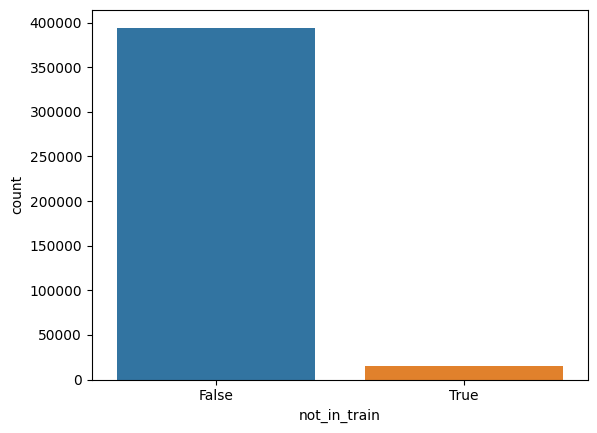

In [270]:
sns.countplot(data, x ='not_in_train')

Top 3 worst predictions by not_in_train
Type: False
1. Edit distance: 32
Word: გადაატრიალ-გადმოატრიალა
Lemma: გადატრიალგადმოტრიალება-გადმოტრიალება
Prediction: ჟეპეგჟჟჟჟჟჟგგგგგგგგგგგჟჟჟჟპლა
2. Edit distance: 23
Word: მივათვალიერ-მოვათვალიერე
Lemma: მითვალიერმოთვალიერება-მოთვალიერება
Prediction: მითალთევილომოოოოვლასობიიერი
3. Edit distance: 19
Word: გაატარ-გამოატარა
Lemma: გატარგამოტარება-გამოტარება
Prediction: საშარამტოგრომოროგრგგლირი

Type: True
1. Edit distance: 20
Word: ფსიქოლოგიურ-მსოფლმხედველობრივი
Lemma: ფსიქოლოგიურმსოფლმხედველობრივი
Prediction: ფკიოლდობერდემომომოვვებერე
2. Edit distance: 18
Word: გაათამაშ-დაინაწილეს
Lemma: გათამაშგამოთამაშება-დანაწილება
Prediction: გათამამანამომარრრრრრევრიეე
3. Edit distance: 17
Word: ოთხმოცდაცხრამეტპროცენტიანი
Lemma: ოთხმოცდაცხრამეტპროცენტიანი
Prediction: ონთმოტლამტრცცცმცემეტიევი

              accuracy  edit_distance   avg_len  norm_distance  inv_distance
not_in_train                                                                
False        

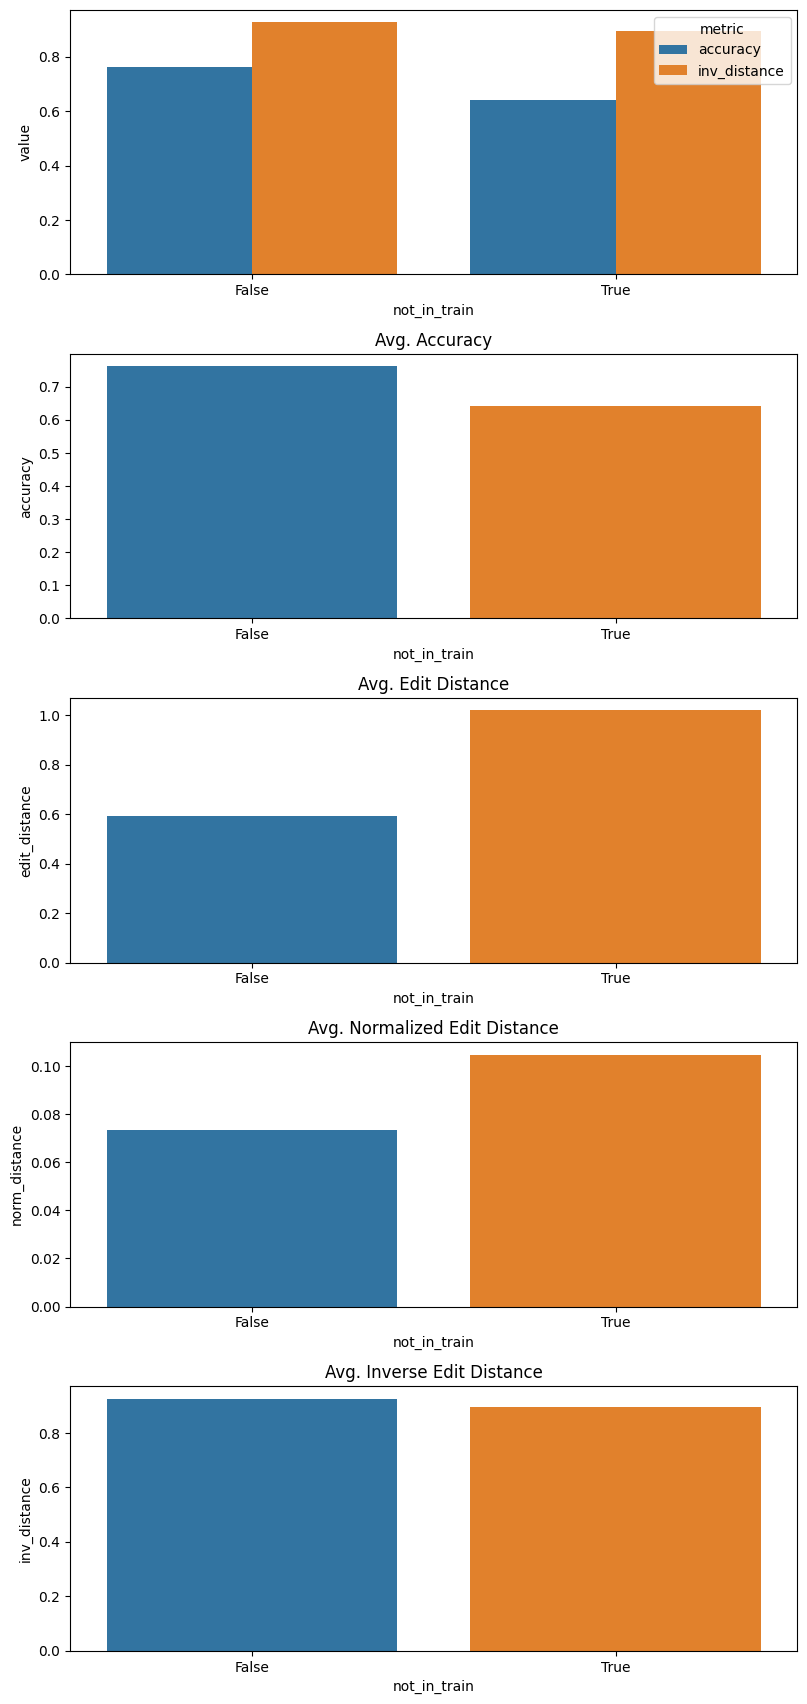

In [271]:
# evaluate_category(result_df, 'not_in_trian')
evaluate_category(result_df, 'not_in_train')

## Edit Distance

In [356]:
result_df['edit_distance_type'] = result_df.apply(lambda x: distance.edit_distance(x.word, x.lemma), axis=1)

<Axes: xlabel='edit_distance_type', ylabel='count'>

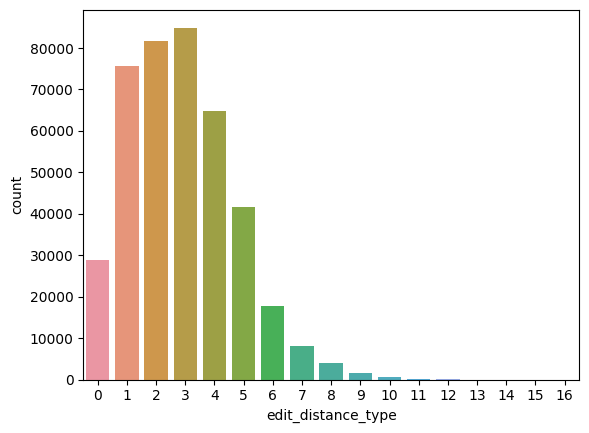

In [357]:
sns.countplot(data, x ='edit_distance_type')

Top 3 worst predictions by edit_distance_type
Type: 1
1. Edit distance: 20
Word: ფსიქოლოგიურ-მსოფლმხედველობრივი
Lemma: ფსიქოლოგიურმსოფლმხედველობრივი
Prediction: ფკიოლდობერდემომომოვვებერე
2. Edit distance: 17
Word: ჰუმანიტარულ-მოხალისეობრივი
Lemma: ჰუმანიტარულმოხალისეობრივი
Prediction: ჰუმანიააარადა-გოცოფფებეფა
3. Edit distance: 15
Word: ისტორიულ-მსოფლმხედველობრივი
Lemma: ისტორიულმსოფლმხედველობრივი
Prediction: ისტორესლო-რომომოხვრელეევი

Type: 2
1. Edit distance: 14
Word: არათანასწორუფლებიანობის
Lemma: არათანასწორუფლებიანობა
Prediction: არათათაძაროოლუფფიძე
2. Edit distance: 13
Word: თბოელექტროცენტრალზე
Lemma: თბოელექტროცენტრალი
Prediction: ნოსელურეენკექნიული
3. Edit distance: 13
Word: ვიცე-თავმჯდომარეს
Lemma: ვიცეთავმჯდომარე
Prediction: თევიაანმდაცორრება

Type: 4
1. Edit distance: 13
Word: მეტყველ-ღაღადებს
Lemma: მეტყველება-ღაღადება
Prediction: სპავველრებიწაა
2. Edit distance: 12
Word: ულტრამემარჯვენეებმა
Lemma: ულტრამემარჯვენე
Prediction: ლდლარსურრეტვანება
3. Edit distance: 12
Word: თექ

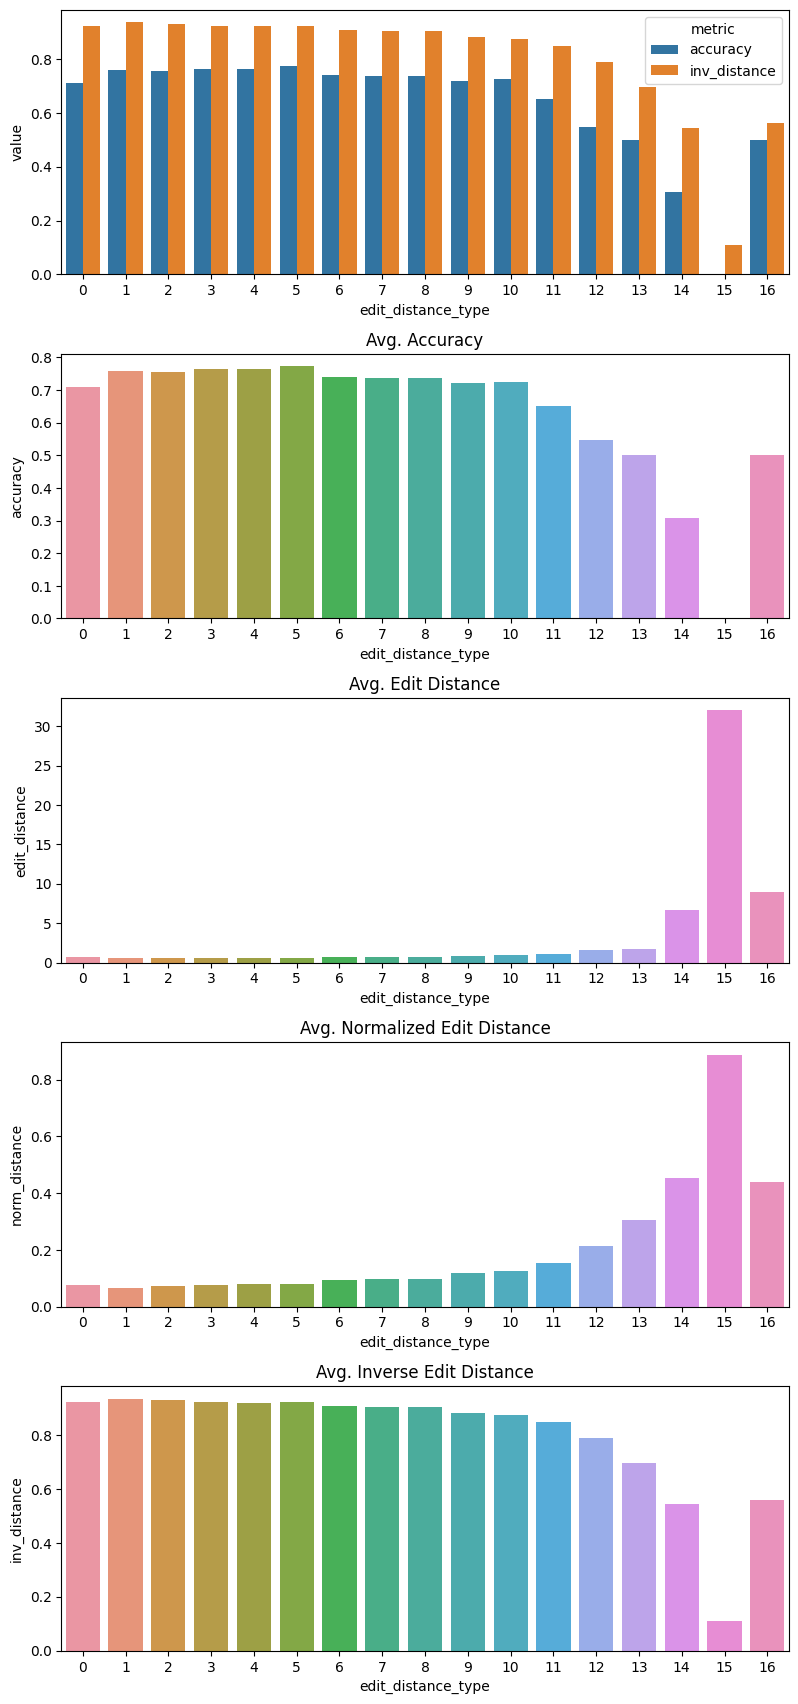

In [359]:
evaluate_category(result_df, 'edit_distance_type')

In [364]:
result_df['normalized_edit_distance_type'] = result_df['edit_distance_type'] / result_df.word.str.len()

In [365]:
result_df['normalized_edit_distance_type'] = pd.qcut(result_df['normalized_edit_distance_type'], q=10)

Top 3 worst predictions by normalized_edit_distance_type
Type: (0.125, 0.182]
1. Edit distance: 13
Word: ვიცეთავმჯდომარეები
Lemma: ვიცეთავმჯდომარე
Prediction: თევიაანმდაცორრება
2. Edit distance: 13
Word: თბოელექტროცენტრალიდან
Lemma: თბოელექტროცენტრალი
Prediction: ნოსელურეენკექნიული
3. Edit distance: 13
Word: თბოელექტროცენტრალებით
Lemma: თბოელექტროცენტრალი
Prediction: ნოსელურეენკექნიული

Type: (0.286, 0.333]
1. Edit distance: 14
Word: გაიკითხ-გამოიკითხეს
Lemma: გაკითხვა-გამოკითხვა
Prediction: პახინსაგვოჭომოცვევა
2. Edit distance: 13
Word: გადააბრუნ-გადმოაბრუნა
Lemma: გადაბრუნება-გადმობრუნება
Prediction: გადბრბუნეჯებეთათოვვებება
3. Edit distance: 12
Word: ჩაისუნთქ-ამოისუნთქავენ
Lemma: ჩასუნთქვა-ამოსუნთქვა
Prediction: ჩასუნთგანა-ვედოოშვანი

Type: (0.182, 0.231]
1. Edit distance: 12
Word: ულტრამემარჯვენეებმა
Lemma: ულტრამემარჯვენე
Prediction: ლდლარსურრეტვანება
2. Edit distance: 11
Word: ამტვრევ-ამსხვრევდა
Lemma: მტვრევა-*მსხვრევა
Prediction: მპრემმტაწვუხევა
3. Edit distance: 11
Word: მოთქუ

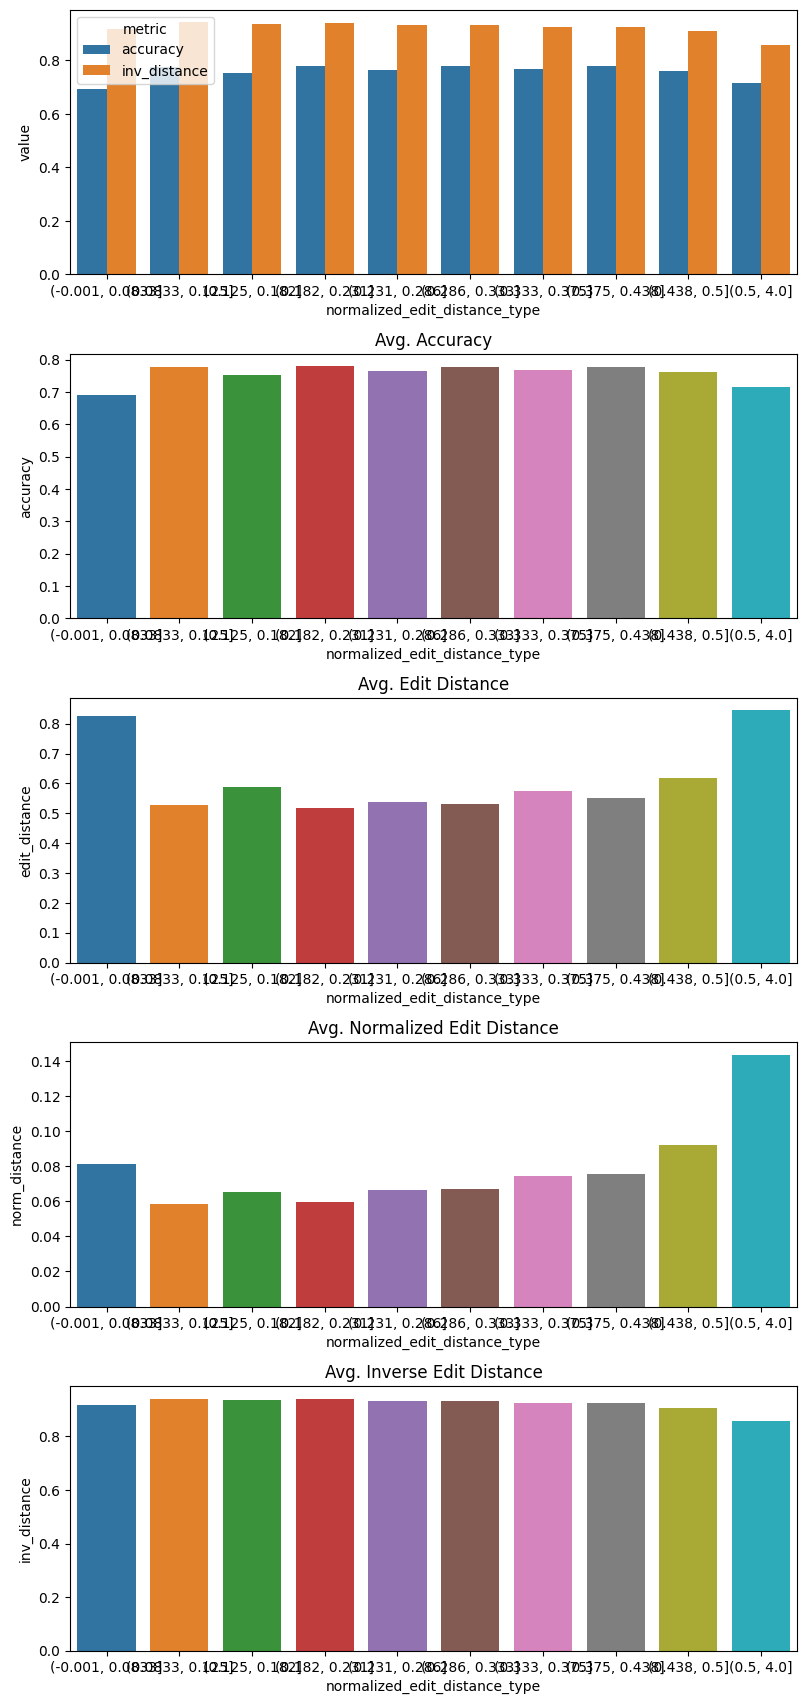

In [366]:
evaluate_category(result_df, 'normalized_edit_distance_type')

## POS Tags

<Axes: xlabel='pos_tag', ylabel='count'>

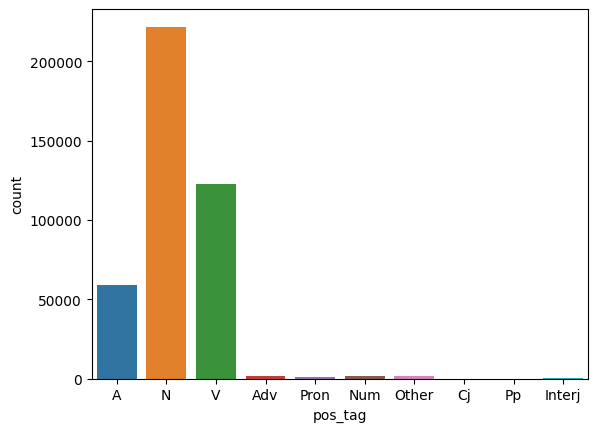

In [272]:
sns.countplot(data, x ='pos_tag')

Top 3 worst predictions by pos_tag
Type: A
1. Edit distance: 20
Word: ფსიქოლოგიურ-მსოფლმხედველობრივი
Lemma: ფსიქოლოგიურმსოფლმხედველობრივი
Prediction: ფკიოლდობერდემომომოვვებერე
2. Edit distance: 17
Word: ოთხმოცდაცხრამეტპროცენტიანი
Lemma: ოთხმოცდაცხრამეტპროცენტიანი
Prediction: ონთმოტლამტრცცცმცემეტიევი
3. Edit distance: 17
Word: ჰუმანიტარულ-მოხალისეობრივი
Lemma: ჰუმანიტარულმოხალისეობრივი
Prediction: ჰუმანიააარადა-გოცოფფებეფა

Type: N
1. Edit distance: 17
Word: დატვირთვა-გადმოტვირთვაში
Lemma: დატვირთვაგადმოტვირთვა
Prediction: დვიტპრაეთთვროთდელიიი
2. Edit distance: 14
Word: არათანასწორუფლებიანობის
Lemma: არათანასწორუფლებიანობა
Prediction: არათათაძაროოლუფფიძე
3. Edit distance: 14
Word: მაღალყოვლადუსამღვდელოესობავ
Lemma: მაღალყოვლადუსამღვდელოესობა
Prediction: მაღალგოყდდამმტყეკლებრეობა

Type: V
1. Edit distance: 32
Word: გადაატრიალ-გადმოატრიალა
Lemma: გადატრიალგადმოტრიალება-გადმოტრიალება
Prediction: ჟეპეგჟჟჟჟჟჟგგგგგგგგგგგჟჟჟჟპლა
2. Edit distance: 23
Word: მივათვალიერ-მოვათვალიერე
Lemma: მითვალ

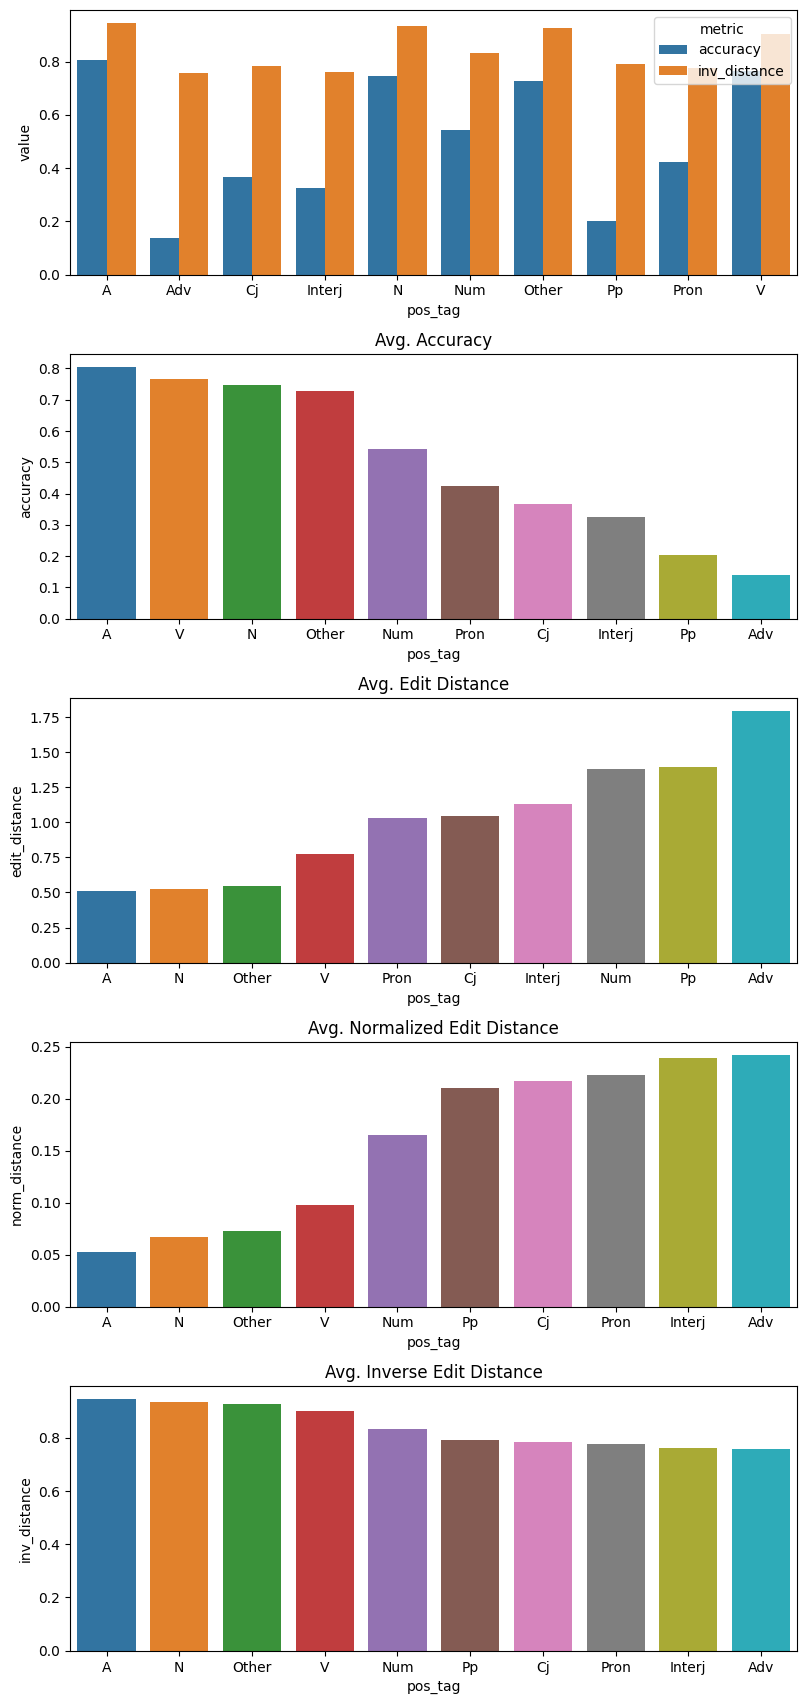

In [273]:
evaluate_category(result_df, 'pos_tag')

## word_length

<Axes: xlabel='word_length_category', ylabel='count'>

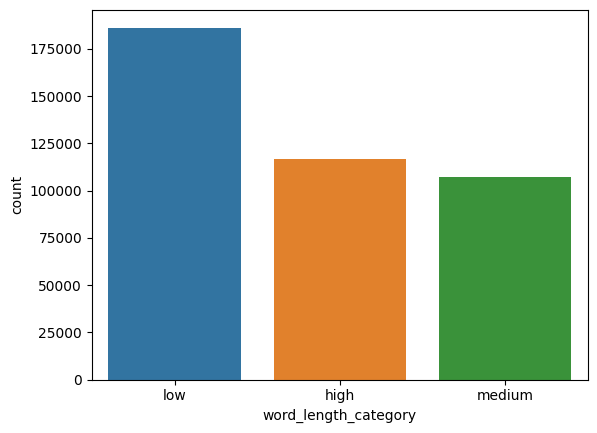

In [274]:
sns.countplot(data, x ='word_length_category')

Top 3 worst predictions by word_length_category
Type: low
1. Edit distance: 11
Word: ერთ-ერთმი
Lemma: შეერთება-*რთმევა
Prediction: შერეთთაამეეეთვვი
2. Edit distance: 9
Word: იფშვნეტ
Lemma: *ფშვნეტა
Prediction: გასანტვჩარი
3. Edit distance: 9
Word: ვფურცლავ
Lemma: *ფურცვლა
Prediction: გასართვუნება

Type: high
1. Edit distance: 32
Word: გადაატრიალ-გადმოატრიალა
Lemma: გადატრიალგადმოტრიალება-გადმოტრიალება
Prediction: ჟეპეგჟჟჟჟჟჟგგგგგგგგგგგჟჟჟჟპლა
2. Edit distance: 23
Word: მივათვალიერ-მოვათვალიერე
Lemma: მითვალიერმოთვალიერება-მოთვალიერება
Prediction: მითალთევილომოოოოვლასობიიერი
3. Edit distance: 20
Word: ფსიქოლოგიურ-მსოფლმხედველობრივი
Lemma: ფსიქოლოგიურმსოფლმხედველობრივი
Prediction: ფკიოლდობერდემომომოვვებერე

Type: medium
1. Edit distance: 10
Word: ვყელყელაობთ
Lemma: *ყელყელაობა
Prediction: გასადეეწყრება
2. Edit distance: 10
Word: ყელყელაობთ
Lemma: *ყელყელაობა
Prediction: გასადეეწყრება
3. Edit distance: 10
Word: უძმობილდები
Lemma: *ძმობილება
Prediction: გაბამძოღელი

                      a

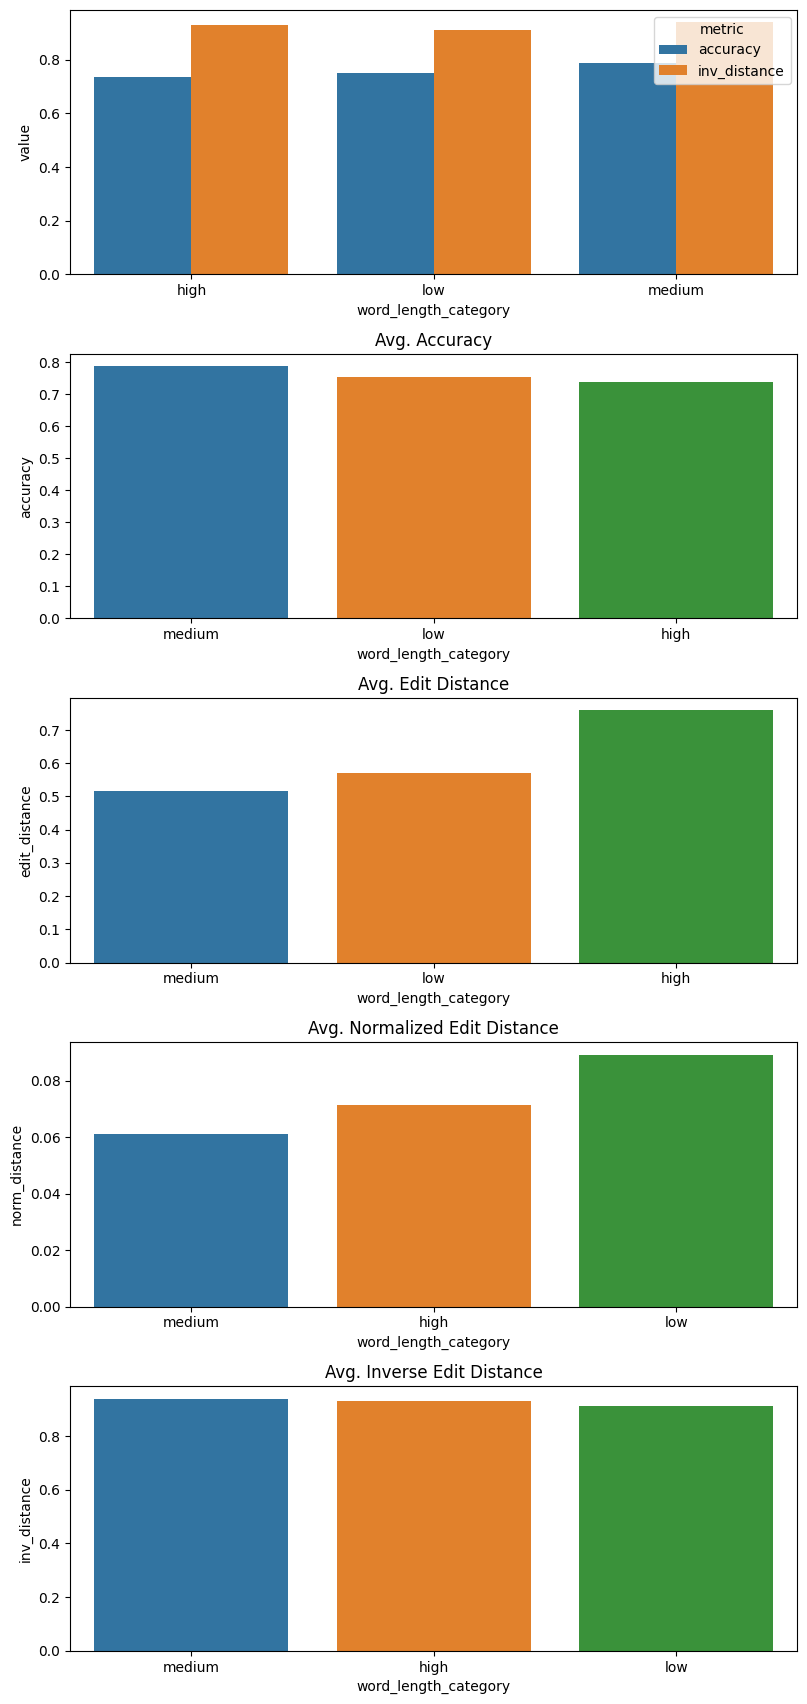

In [275]:
evaluate_category(result_df, 'word_length_category')

## lemma length

<Axes: xlabel='lemma_length_category', ylabel='count'>

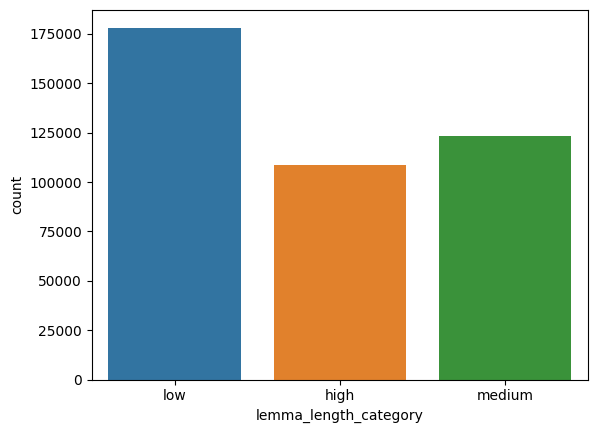

In [276]:
sns.countplot(data, x ='lemma_length_category')

Top 3 worst predictions by lemma_length_category
Type: low
1. Edit distance: 9
Word: იქუფრებოდნენ
Lemma: *ქუფვრა
Prediction: გაკარუვლება
2. Edit distance: 9
Word: იქუფრებოდა
Lemma: *ქუფვრა
Prediction: გაკარუვლება
3. Edit distance: 9
Word: ჩურთვენ
Lemma: *ჩურთუა
Prediction: გალანწუუვი

Type: high
1. Edit distance: 32
Word: გადაატრიალ-გადმოატრიალა
Lemma: გადატრიალგადმოტრიალება-გადმოტრიალება
Prediction: ჟეპეგჟჟჟჟჟჟგგგგგგგგგგგჟჟჟჟპლა
2. Edit distance: 23
Word: მივათვალიერ-მოვათვალიერე
Lemma: მითვალიერმოთვალიერება-მოთვალიერება
Prediction: მითალთევილომოოოოვლასობიიერი
3. Edit distance: 20
Word: ფსიქოლოგიურ-მსოფლმხედველობრივი
Lemma: ფსიქოლოგიურმსოფლმხედველობრივი
Prediction: ფკიოლდობერდემომომოვვებერე

Type: medium
1. Edit distance: 9
Word: ჰფურცლა
Lemma: *ფურცვლა
Prediction: გასართვუნება
2. Edit distance: 9
Word: გიჩხვლეტ
Lemma: *ჩხვლეტა
Prediction: გალაწხლეჩება
3. Edit distance: 9
Word: ჩხვლეტს
Lemma: *ჩხვლეტა
Prediction: გალაწხლეჩება

                       accuracy  edit_distance    avg_len 

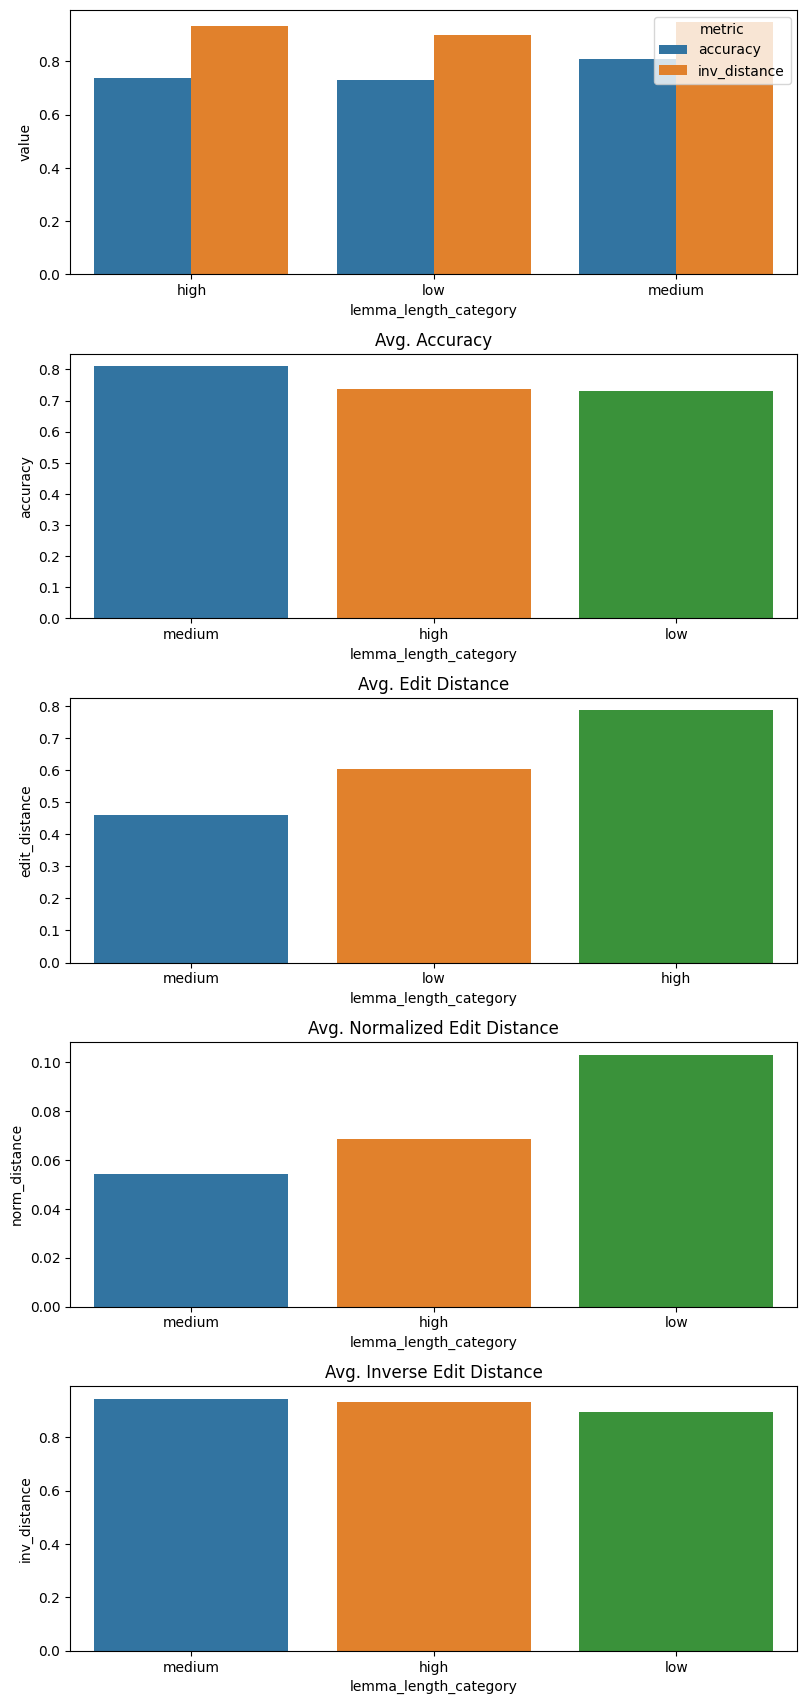

In [277]:
evaluate_category(result_df, 'lemma_length_category')

## Word Length / Lemma Length Ratio

<Axes: xlabel='ratio_category', ylabel='count'>

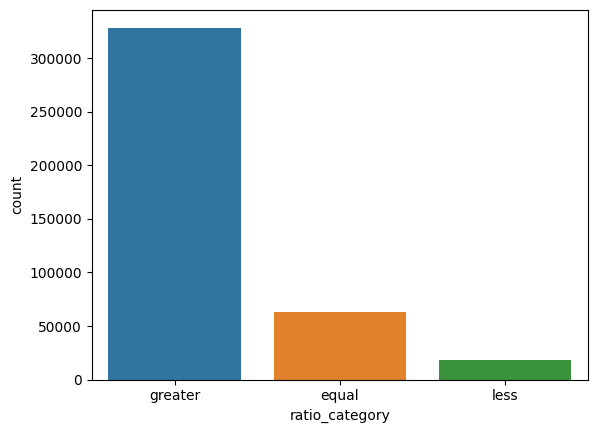

In [278]:
sns.countplot(data, x ='ratio_category')

Top 3 worst predictions by ratio_category
Type: greater
1. Edit distance: 20
Word: ფსიქოლოგიურ-მსოფლმხედველობრივი
Lemma: ფსიქოლოგიურმსოფლმხედველობრივი
Prediction: ფკიოლდობერდემომომოვვებერე
2. Edit distance: 17
Word: ჰუმანიტარულ-მოხალისეობრივი
Lemma: ჰუმანიტარულმოხალისეობრივი
Prediction: ჰუმანიააარადა-გოცოფფებეფა
3. Edit distance: 17
Word: დატვირთვა-გადმოტვირთვაში
Lemma: დატვირთვაგადმოტვირთვა
Prediction: დვიტპრაეთთვროთდელიიი

Type: equal
1. Edit distance: 17
Word: ოთხმოცდაცხრამეტპროცენტიანი
Lemma: ოთხმოცდაცხრამეტპროცენტიანი
Prediction: ონთმოტლამტრცცცმცემეტიევი
2. Edit distance: 14
Word: გაიკითხ-გამოიკითხეს
Lemma: გაკითხვა-გამოკითხვა
Prediction: პახინსაგვოჭომოცვევა
3. Edit distance: 14
Word: ათასასოთხმოცდათოთხმეტი
Lemma: ათასასოთხმოცდათოთხმეტი
Prediction: ათასათოსსამხლომოოტრმა

Type: less
1. Edit distance: 32
Word: გადაატრიალ-გადმოატრიალა
Lemma: გადატრიალგადმოტრიალება-გადმოტრიალება
Prediction: ჟეპეგჟჟჟჟჟჟგგგგგგგგგგგჟჟჟჟპლა
2. Edit distance: 23
Word: მივათვალიერ-მოვათვალიერე
Lemma: მითვალ

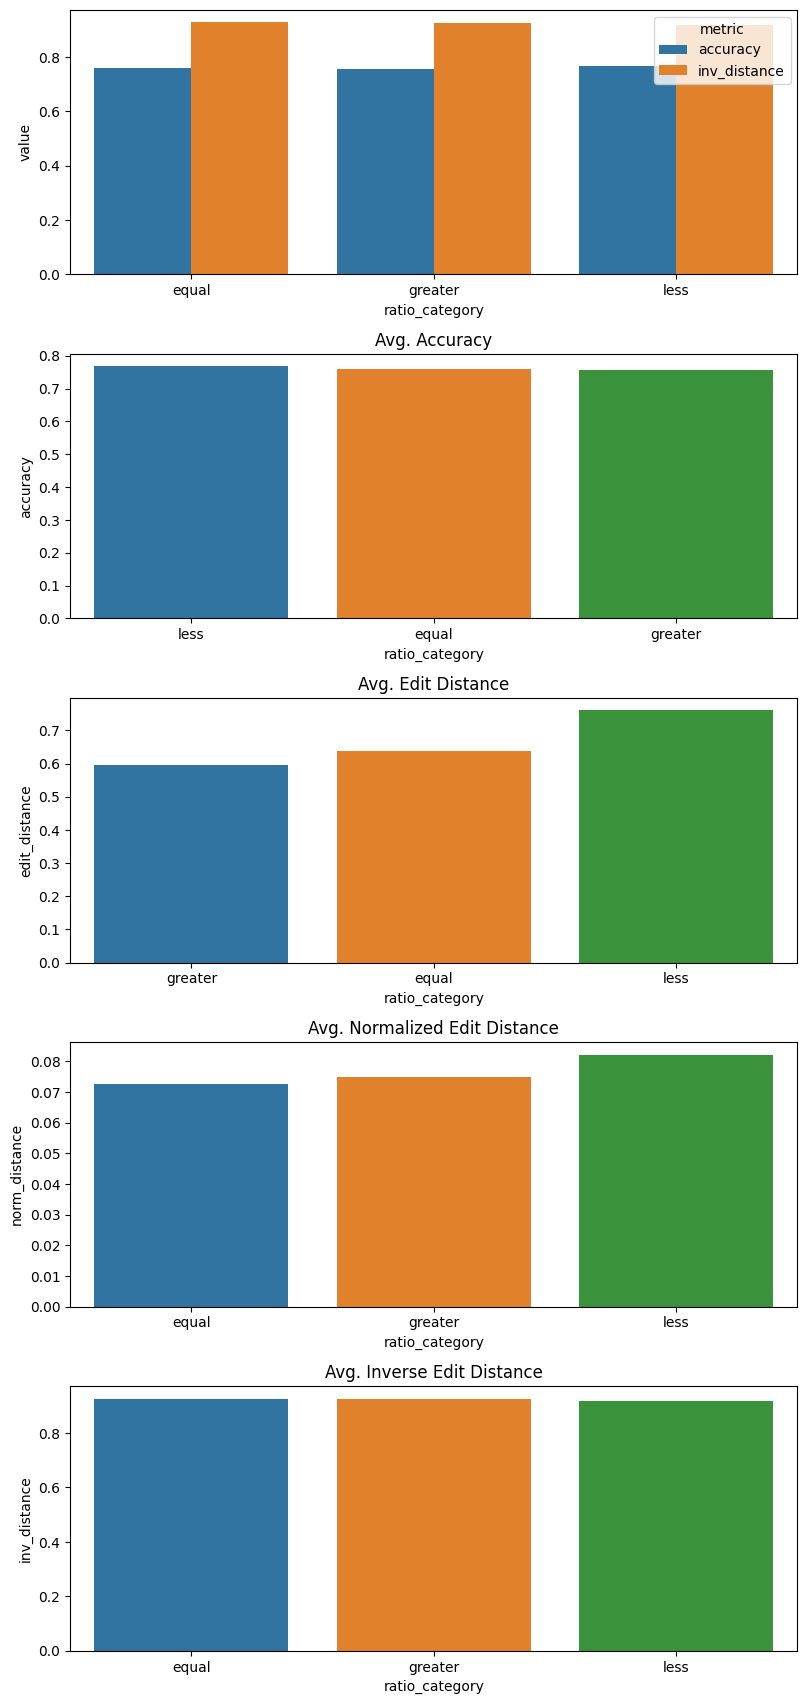

In [279]:
evaluate_category(result_df, 'ratio_category')

## Frequencies

<Axes: xlabel='freq_category', ylabel='count'>

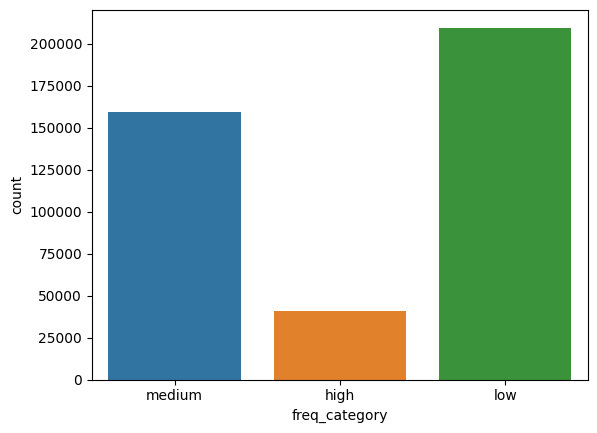

In [280]:
sns.countplot(data, x ='freq_category')

Top 3 worst predictions by freq_category
Type: medium
1. Edit distance: 32
Word: გადაატრიალ-გადმოატრიალა
Lemma: გადატრიალგადმოტრიალება-გადმოტრიალება
Prediction: ჟეპეგჟჟჟჟჟჟგგგგგგგგგგგჟჟჟჟპლა
2. Edit distance: 23
Word: მივათვალიერ-მოვათვალიერე
Lemma: მითვალიერმოთვალიერება-მოთვალიერება
Prediction: მითალთევილომოოოოვლასობიიერი
3. Edit distance: 19
Word: გაატარ-გამოატარა
Lemma: გატარგამოტარება-გამოტარება
Prediction: საშარამტოგრომოროგრგგლირი

Type: high
1. Edit distance: 12
Word: ქმედუნარიანობა
Lemma: ქმედუნარიანობა
Prediction: ჭქალიგერაგიძეა
2. Edit distance: 11
Word: ტანკსაწინააღმდეგო
Lemma: ტანკსაწინააღმდეგო
Prediction: ტკანანთწემანისეგი
3. Edit distance: 11
Word: საღვთისმსახურო
Lemma: საღვთისმსახურო
Prediction: გასხუთთღემრათრი

Type: low
1. Edit distance: 20
Word: ფსიქოლოგიურ-მსოფლმხედველობრივი
Lemma: ფსიქოლოგიურმსოფლმხედველობრივი
Prediction: ფკიოლდობერდემომომოვვებერე
2. Edit distance: 18
Word: გაათამაშ-გამოათამაშა
Lemma: გათამაშგამოთამაშება-გამოთამაშება
Prediction: გათამამანამმომოდავებე

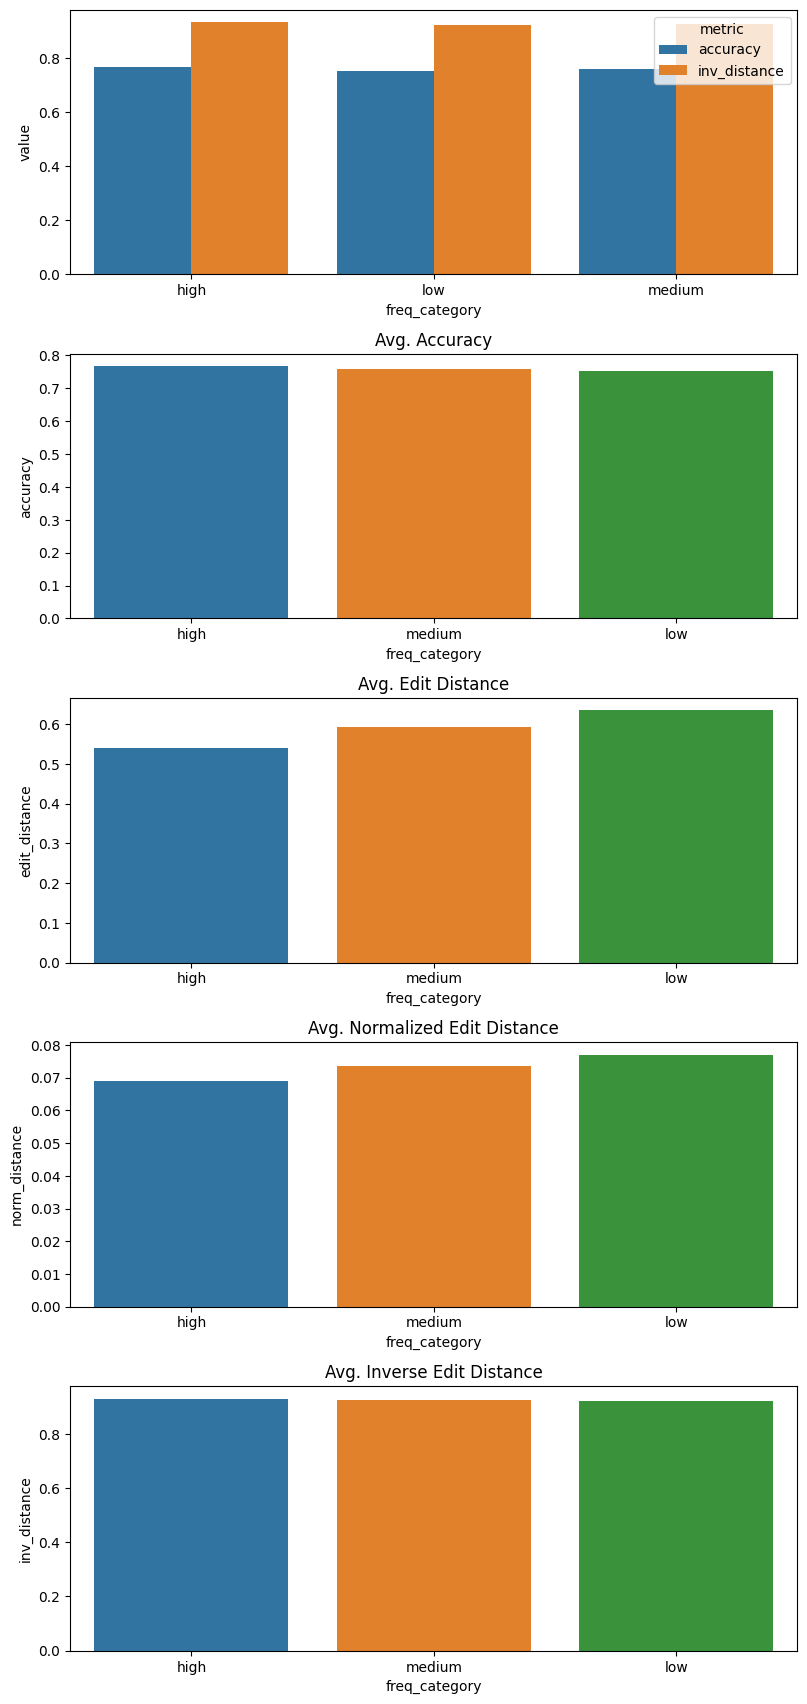

In [281]:
evaluate_category(result_df, 'freq_category')

## Reported Speech

<Axes: xlabel='reported_speech', ylabel='count'>

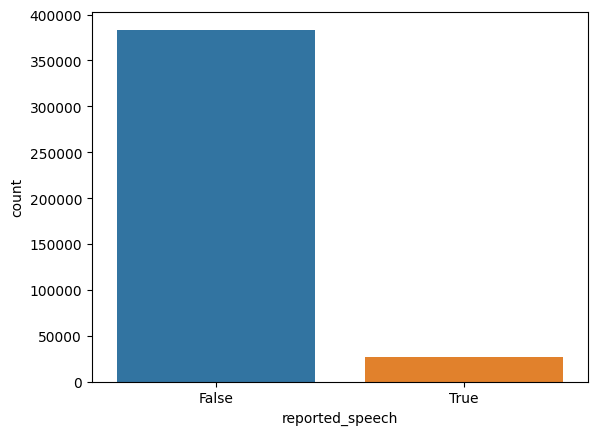

In [282]:
sns.countplot(data, x ='reported_speech')

Top 3 worst predictions by reported_speech
Type: False
1. Edit distance: 32
Word: გადაატრიალ-გადმოატრიალა
Lemma: გადატრიალგადმოტრიალება-გადმოტრიალება
Prediction: ჟეპეგჟჟჟჟჟჟგგგგგგგგგგგჟჟჟჟპლა
2. Edit distance: 23
Word: მივათვალიერ-მოვათვალიერე
Lemma: მითვალიერმოთვალიერება-მოთვალიერება
Prediction: მითალთევილომოოოოვლასობიიერი
3. Edit distance: 20
Word: ფსიქოლოგიურ-მსოფლმხედველობრივი
Lemma: ფსიქოლოგიურმსოფლმხედველობრივი
Prediction: ფკიოლდობერდემომომოვვებერე

Type: True
1. Edit distance: 13
Word: ეროვნულ-განმათავისუფლებელიო
Lemma: ეროვნულგანმათავისუფლებელი
Prediction: ეროვნგლათავრამოორრავებელი
2. Edit distance: 10
Word: ფიზიკა-მათემატიკაო
Lemma: ფიზიკამათემატიკა
Prediction: ფინისამაცვისფოსი
3. Edit distance: 10
Word: სოცუზრუნველყოფისო
Lemma: სოცუზრუნველყოფა
Prediction: სუცოზრონაცოვვლე

                 accuracy  edit_distance   avg_len  norm_distance  \
reported_speech                                                     
False            0.754008       0.612412  8.156891       0.075079   


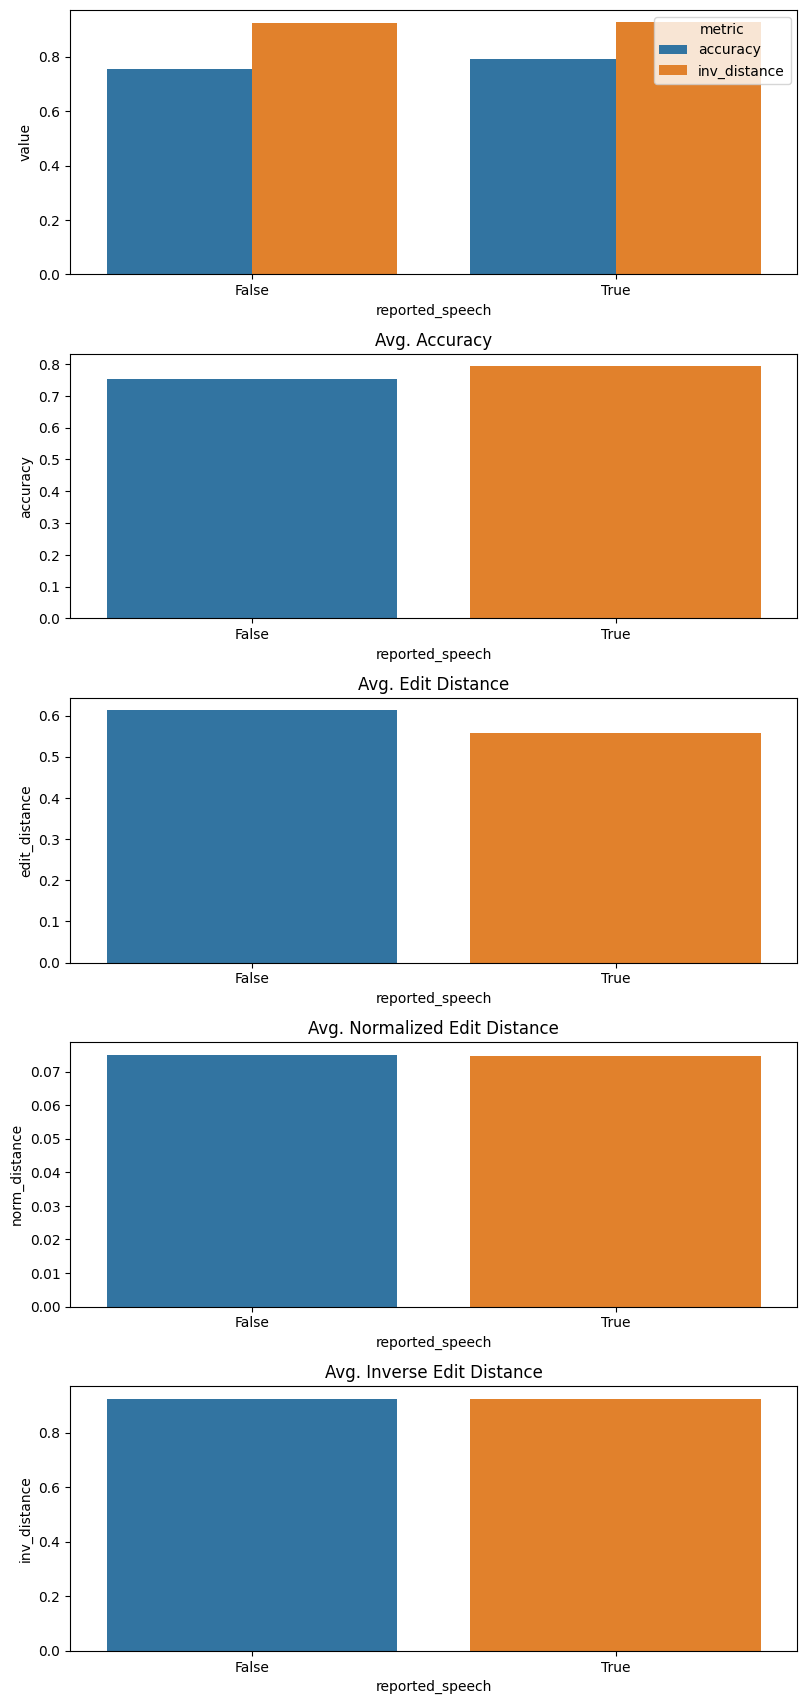

In [284]:
evaluate_category(result_df, 'reported_speech')

In [301]:
def get_pred(word: str):
    pad = [vocab[PAD_TOKEN]] * MAX_LENGTH
    word = [vocab[ch] for ch in word] + [vocab[EOW_TOKEN]]
    pad[: len(word)] = word
    inp = torch.unsqueeze(torch.tensor(pad), dim=0)
    return word. tensors_to_words(model(inp).argmax(dim=2))[0]

In [338]:
get_pred('ნივრის')

'ნივრი'

In [339]:
get_pred('ლიმონის')

'ლიმონი'

In [351]:
print(get_pred('ვტირი'))
print(get_pred('ტირი'))
print(get_pred('ტირის'))
print(get_pred('ვტირით'))
print(get_pred('ტირით'))
print(get_pred('ტირიან'))

ტირილი
ტირი
ტირი
ტირილი
ტირი
ტირიანი


In [352]:
print(get_pred('ვტიროდი'))
print(get_pred('ტიროდი'))
print(get_pred('ტიროდა'))
print(get_pred('ვტიროდით'))
print(get_pred('ტიროდით'))
print(get_pred('ტიროდნენ'))

ტირილი
ტირო
ტირო
ტირილი
ტიროდი
ტირილი


In [353]:
print(get_pred('ვიტირებ'))
print(get_pred('იტირებ'))
print(get_pred('იტირებს'))
print(get_pred('ვიტირებთ'))
print(get_pred('იტირებთ'))
print(get_pred('იტირებენ'))

*იტირება
*იტირება
*ტირება
*იტირება
*იტირება
*იტირება


In [354]:
print(get_pred('მეტირა')) 
print(get_pred('გეტირა'))
print(get_pred('ეტირა'))
print(get_pred('გვეტირა'))
print(get_pred('გეტირათ'))
print(get_pred('ეტირათ'))

ტრილი
ტირილი
ტირილი
ტირილი
ტირილი
ტირილი


In [355]:
print(get_pred('მიტირია')) 
print(get_pred('გიტირია'))
print(get_pred('უტირია'))
print(get_pred('გვიტირია'))
print(get_pred('გიტირიათ'))
print(get_pred('უტირიათ'))

ტირილი
ტირილი
უტირი
ტირილი
ტირილი
ტირილი
